In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("./samples"))

# Any results you write to the current directory are saved as output.

['226md.png', '22d5n.png', '2356g.png', '23mdg.png', '23n88.png', '243mm.png', '244e2.png', '245y5.png', '24f6w.png', '24pew.png', '25257.png', '253dc.png', '25egp.png', '25m6p.png', '25p2m.png', '25w53.png', '264m5.png', '268g2.png', '28348.png', '28x47.png', '2b827.png', '2bg48.png', '2cegf.png', '2cg58.png', '2cgyx.png', '2en7g.png', '2enf4.png', '2fxgd.png', '2g783.png', '2g7nm.png', '2gyb6.png', '2mg87.png', '2mpnn.png', '2n73f.png', '2nbc5.jpg', '2nbcx.png', '2nf26.png', '2npg6.png', '2nx38.png', '2p2y8.png', '2pfpn.png', '2w4y7.png', '2wc38.png', '2wx73.png', '2x7bm.png', '2xc2n.png', '2ycn8.png', '2yggg.png', '325fb.png', '32cnn.png', '32dnn.png', '33b22.png', '33f7m.png', '33n73.png', '33ng4.png', '33p4e.png', '34b84.png', '34fxm.png', '34pcn.png', '368y5.png', '36bc2.png', '36nx4.png', '36w25.png', '373gb.png', '377xx.png', '378e5.png', '37d52.png', '37ep6.png', '387g2.png', '38n57.png', '3b4we.png', '3bd8f.png', '3bfnd.png', '3bnyf.png', '3bx86.png', '3c7de.jpg', '3cpwb.png'

In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [3]:
print(num_symbols)

36


In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [6]:
def preprocess_data():
    n_samples = len(os.listdir('./samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('./samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('./samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [7]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [12]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 3s 118ms/step - loss: 4.1061 - dense_1_loss: 0.4326 - dense_3_loss: 0.9094 - dense_5_loss: 0.9231 - dense_7_loss: 0.9956 - dense_9_loss: 0.8454 - dense_1_accuracy: 0.8209 - dense_3_accuracy: 0.6495 - dense_5_accuracy: 0.6572 - dense_7_accuracy: 0.6314 - dense_9_accuracy: 0.6714 - val_loss: 12.1749 - val_dense_1_loss: 9.1984 - val_dense_3_loss: 0.7664 - val_dense_5_loss: 0.8895 - val_dense_7_loss: 0.8362 - val_dense_9_loss: 0.4844 - val_dense_1_accuracy: 0.0309 - val_dense_3_accuracy: 0.8196 - val_dense_5_accuracy: 0.7062 - val_dense_7_accuracy: 0.7629 - val_dense_9_accuracy: 0.8557
Epoch 2/30
25/25 [==============================] - 3s 119ms/step - loss: 3.9941 - dense_1_loss: 0.4415 - dense_3_loss: 0.9757 - dense_5_loss: 0.8729 - dense_7_loss: 0.9134 - dense_9_loss: 0.7906 - dense_1_accuracy: 0.8222 - dense_3_accuracy: 0.6392 - dense_5_accuracy: 0.6881 - dense_7_accuracy: 0.6675 - dense_9_accuracy: 0.6817 - val_loss: 10.6049 - val_de

In [11]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [13]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 16ms/step - loss: 18.0125 - dense_1_loss: 16.0019 - dense_3_loss: 0.2977 - dense_5_loss: 0.6466 - dense_7_loss: 0.7825 - dense_9_loss: 0.2839 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9400 - dense_5_accuracy: 0.8400 - dense_7_accuracy: 0.8100 - dense_9_accuracy: 0.9200
Test Loss and accuracy: [18.01252555847168, 16.001928329467773, 0.2976513206958771, 0.6465710997581482, 0.7824808359146118, 0.283892959356308, 0.0, 0.9399999976158142, 0.8399999737739563, 0.8100000023841858, 0.9200000166893005]


In [14]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('./samples/8n5p3.png'))
print(predict('./samples/f2m8n.png'))
print(predict('./samples/dce8y.png'))
print(predict('./samples/3eny7.png'))
print(predict('./samples/npxb7.png'))

1/1 [==============================] - 0s 137ms/step
8n5p3
1/1 [==============================] - 0s 19ms/step
f2m8n
1/1 [==============================] - 0s 19ms/step
dce8y
1/1 [==============================] - 0s 18ms/step
3eny7
1/1 [==============================] - 0s 18ms/step
mpxb7


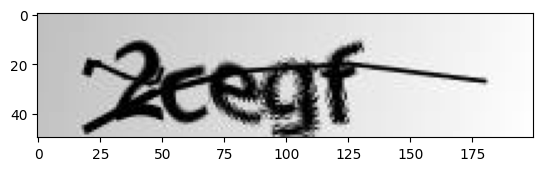

In [15]:
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('./samples/2cegf.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print("Predicted Captcha =",predict('./samples/2cegf.png'))